### Titanic Survival Prediction

#### Feature Enginnering

In [1]:
# to handle datasets
import pandas as pd
import numpy as np
 
# for text / string processing
import re
 
# for plotting
import matplotlib.pyplot as plt
% matplotlib inline
 
# to divide train and test set
from sklearn.model_selection import train_test_split
 
# feature scaling
from sklearn.preprocessing import MinMaxScaler
 
# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
 
 
# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
 
# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics
 
pd.pandas.set_option('display.max_columns', None)
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# data for kaggle submission
submission = pd.read_csv('test.csv')
submission.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Types of Variables

In [4]:
# Inspecting the variables types
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

There ara a mix of categorical and numerical variables. PassengerId is a unique ID assigned to each passenger and cannot be used aa a variable.

In [5]:
print("Number of PassengerId Levels : ", len(data.PassengerId.unique()))
print("Number of Passengers on the Titanic : ", len(data))

Number of PassengerId Levels :  891
Number of Passengers on the Titanic :  891


In [6]:
# find categorical features
categorical = [var for var in data.columns if data[var].dtype == 'O']
print("There are {} categorical features".format(len(categorical)))

There are 5 categorical features


In [7]:
# find Numerical features
numerical = [var for var in data.columns if data[var].dtype != 'O']
print("There are {} numerical features".format(len(numerical)))

There are 7 numerical features


In [8]:
# view of categorical features
data[categorical].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


Cabin and Ticket contains data of mixed type, both string and numerical, which can be separated into two features of numeric and string

In [9]:
# view of numerical features
data[numerical].head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


- 3 Discrete variables: Pclass, SibSp and Parch
- 2 continuous variables: Fare and Age
- 1 Id variable: PassengerId (it is a label for each of the passengers)
- 1 binary: Survived (target variable).

In [10]:
# values in discrete variables
for var in ['Pclass', 'SibSp', 'Parch']:
    print(var, 'values: ', data[var].unique())

Pclass values:  [3 1 2]
SibSp values:  [1 0 3 4 2 5 8]
Parch values:  [0 1 2 5 3 4 6]


#### Missing Values

In [11]:
# percentage of missing values in the variables
data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Three variables Age, Cabin and Embarked contains missing values

#### Outliers

In [12]:
numerical = [var for var in numerical if var not in ['PassengerId','Survived']]
numerical

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Text(0,0.5,'Fare')

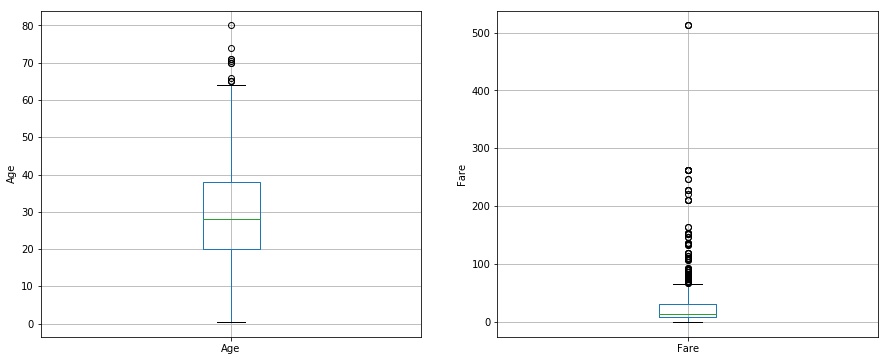

In [13]:
# boxplot to visualise outliers in continuos variables - Age and Fare
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
fig = data.boxplot(column = 'Age')
fig.set_ylabel('Age')

plt.subplot(1,2,2)
fig = data.boxplot(column = "Fare")
fig.set_ylabel('Fare')


Both the variables contains outliers. Lets visualize the variables with histograms.

Text(0,0.5,'Number of Passengers')

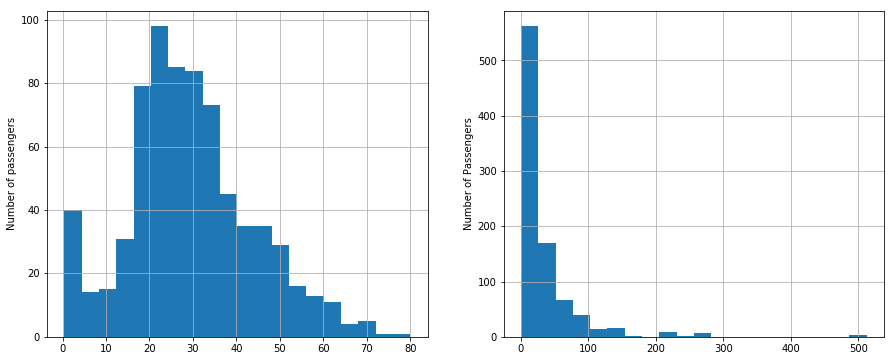

In [14]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
fig = data.Age.hist(bins = 20)
fig.set_ylabel('Number of passengers')

plt.subplot(1,2,2)
fig = data.Fare.hist(bins = 20)
fig.set_ylabel('Number of Passengers')

Age is farily normaly distributed while Fare is highly skewed.

In [16]:
# Find outliers

# Age - assuming Gaussian distibution
upper_limit = data.Age.mean() + 3*data.Age.std()
lower_limit = data.Age.mean() - 3*data.Age.std()
print('Age outliers are values > {upperlimit} or < {lowerlimit}'.format(upperlimit = upper_limit, lowerlimit = lower_limit))

# Fare - using interquantile range
IQR = data.Fare.quantile(0.75) - data.Fare.quantile(0.25)
upper_fence = data.Fare.quantile(0.75) + 3 * IQR
lower_fence = data.Fare.quantile(0.25) - 3 * IQR
print('Fare outliers are values > {upperlimit} or < {lowerlimit}'.format(upperlimit = upper_fence, lowerlimit = lower_fence))


Age outliers are values > 73.27860964406095 or < -13.88037434994331
Fare outliers are values > 100.2688 or < -61.358399999999996


We should remove values in Age greater than 73 and for Fare values greater than 100
There are different ways to handle outliers. Here for Age we will use top encoding and for Fare we will use discretization

In [17]:
# outliers in discrete variables
for var in ['Pclass',  'SibSp', 'Parch']:
    print(data[var].value_counts()/np.float(len(data)))

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64
0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64


We will consider values that are present in less than 1% as outliers.

Pclass does not contain outliers, as all its numbers are present in at least 20% of the passengers.

SibSp This variable indicates the number of of siblings / spouses aboard the Titanic. Values bigger than 4, are rare. So we will cap this variable at 4 (top coding).

Parch This variable indicates the number of parents / children aboard the Titanic. We can see that values > 2 are rare (present in less than 1% of passengers). Thus we will cap this variable at 2 (top-coding).

In [18]:
# Cardinality: Number of labels in categorical variables
for var in categorical:
    print("Number of labels in ", var, ':', len(data[var].unique()))

Number of labels in  Name : 891
Number of labels in  Sex : 2
Number of labels in  Ticket : 681
Number of labels in  Cabin : 148
Number of labels in  Embarked : 4


We see that Name, Ticket and Cabin has many labels and they also need to be pre processed.

#### Pre-processing of mixed type of variables

The variables Cabin and Ticket contain both numbers and letters. Let's create 2 variables for each extracting the numerical and categorical part.

In [19]:
# cabin

data['Cabin_numerical'] = data.Cabin.str.extract('(\d+)')  # extract numbers
data['Cabin_numerical'] = data['Cabin_numerical'].astype(float) # parsing to float type

data['Cabin_categorical'] = data['Cabin'].str[0] # extract the first letter in Cabin

# do the same for submission data

submission['Cabin_numerical'] = submission.Cabin.str.extract('(\d+)')  # extract numbers
submission['Cabin_numerical'] = submission['Cabin_numerical'].astype(float) # parsing to float type

submission['Cabin_categorical'] = submission['Cabin'].str[0] # extract the first letter in Cabin

#check newly created features
data[['Cabin','Cabin_numerical','Cabin_categorical']].head()

,Cabin,Cabin_numerical,Cabin_categorical
0,NaN,NaN,NaN
1,C85,85.0,C
2,NaN,NaN,NaN
3,C123,123.0,C
4,NaN,NaN,NaN


In [20]:
# drop the original Cabin variable
data.drop('Cabin', axis = 1, inplace = True)
submission.drop('Cabin', axis = 1, inplace = True)

In [21]:
# processing ticket variable
# eaxtract last part of ticket as numerical
data['Ticket_numerical'] = data['Ticket'].apply(lambda s: s.split()[-1])
data['Ticket_numerical'] = np.where(data['Ticket_numerical'].str.isdigit(), data['Ticket_numerical'],np.nan)
data['Ticket_numerical'] = data['Ticket_numerical'].astype(float)

#extract the first part as category
data['Ticket_categorical'] = data['Ticket'].apply(lambda s:s.split()[0])
data['Ticket_categorical'] = np.where(data['Ticket_categorical'].str.isdigit(),np.nan, data['Ticket_categorical'])

# for submission data
# eaxtract last part of ticket as numerical
submission['Ticket_numerical'] = submission['Ticket'].apply(lambda s: s.split()[-1])
submission['Ticket_numerical'] = np.where(submission['Ticket_numerical'].str.isdigit(), submission['Ticket_numerical'],np.nan)
submission['Ticket_numerical'] = submission['Ticket_numerical'].astype(float)

#extract the first part as category
submission['Ticket_categorical'] = submission['Ticket'].apply(lambda s:s.split()[0])
submission['Ticket_categorical'] = np.where(submission['Ticket_categorical'].str.isdigit(),np.nan, submission['Ticket_categorical'])
                                                                              
data[['Ticket', 'Ticket_numerical', 'Ticket_categorical']].head()                                      

,Ticket,Ticket_numerical,Ticket_categorical
0,A/5 21171,21171.0,A/5
1,PC 17599,17599.0,PC
2,STON/O2. 3101282,3101282.0,STON/O2.
3,113803,113803.0,NaN
4,373450,373450.0,NaN


In [22]:
# Further exploring the Ticket_categorical variable
data.Ticket_categorical.unique()

array(['A/5', 'PC', 'STON/O2.', nan, 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'STON/O', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'LINE', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

It still contains many labels and some labels are similar. So, lets further manipulate the labels

In [23]:
# remove non letter characterd from the labels
text = data.Ticket_categorical.apply(lambda x: re.sub('[^a-zA-Z]', '', str(x)))

#compare with the original labels
pd.concat([text,data.Ticket_categorical],axis = 1).head()

,Ticket_categorical,Ticket_categorical
0,A,A/5
1,PC,PC
2,STONO,STON/O2.
3,nan,NaN
4,nan,NaN


In [24]:
# set the new labels to upper case and now we fewer labels
text = text.str.upper()
text.unique()

array(['A', 'PC', 'STONO', 'NAN', 'PP', 'CA', 'SCPARIS', 'SCA', 'SP',
       'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SOP', 'FA', 'LINE', 'FCC',
       'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS', 'SOPP', 'FC', 'SOTONO',
       'CASOTON'], dtype=object)

In [25]:
# processing the variable in submission data
data['Ticket_categorical'] = text

submission['Ticket_categorical'] = submission['Ticket_categorical'].apply(lambda x: re.sub('[^a-zA-Z]','',str(x)))
submission['Ticket_categorical'] = submission['Ticket_categorical'].str.upper()


In [26]:
# drop the original Ticket variable
data.drop('Ticket',axis = 1, inplace = True)
submission.drop('Ticket', axis = 1, inplace = True)

The variable Name contains 891 different values, one for each of the passengers. We wouldn't be able to use this variable as is. However, we can extract some data from it, for example the title. 

In [27]:
# function to extract title from names

def get_title (passenger):
    #extract the title from the name
    name = passenger
    if re.search ('Mrs', name):
        return 'Mrs'
    elif re.search ('Mr', name):
        return 'Mr'
    elif re.search('Miss', name):
        return 'Miss'
    elif re.search('Master',name):
        return'Master'
    else:
        return 'Other'
    
data['Title'] = data['Name'].apply(get_title)
submission['Title'] = submission['Name'].apply(get_title)

data[['Name','Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [28]:
# remove the original variable
data.drop('Name', axis = 1, inplace = True)
submission.drop('Name', axis = 1, inplace = True)

1     0.602694
2     0.180696
3     0.114478
4     0.032548
6     0.024691
5     0.016835
7     0.013468
11    0.007856
8     0.006734
Name: Family_size, dtype: float64


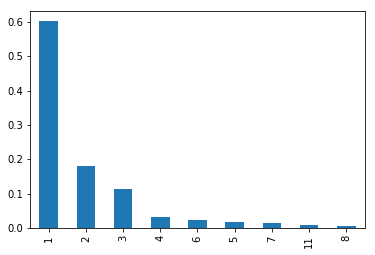

In [29]:
## create a variable indicating family size (including the passenger)
# sums siblings and parents

data['Family_size'] = data.SibSp + data.Parch + 1
submission['Family_size'] = submission.SibSp + submission.Parch + 1

print(data.Family_size.value_counts()/np.float(len(data)))

(data.Family_size.value_counts()/np.float(len(data))).plot.bar()


The new variable Family size is discrete, because it is the sum of 2 discrete variables. It takes a finite number of values, and large families were rare on the Titanic. In fact, families larger than 7 people were rare, so we will cap family size at 7.

In [30]:
# variable indicating if passenger was mother
data['is_mother'] = np.where((data.Sex == 'female') & (data.Parch >=1) &(data.Age>18),1,0)
submission['is_mother'] = np.where((submission.Sex == 'female') & (submission.Parch >=1) &(submission.Age>18),1,0)

data[['Sex', 'Parch', 'Age', 'is_mother']].head()

,Sex,Parch,Age,is_mother
0,male,0,22.0,0
1,female,0,38.0,0
2,female,0,26.0,0
3,female,0,35.0,0
4,male,0,35.0,0


In [31]:
data.loc[data.is_mother ==1,['Sex', 'Parch', 'Age', 'is_mother']].head()

,Sex,Parch,Age,is_mother
8,female,2,27.0,1
25,female,5,38.0,1
88,female,2,23.0,1
98,female,1,34.0,1
136,female,2,19.0,1


In [32]:
print('There were {} mothers in the Titanic'.format(data.is_mother.sum()))

There were 64 mothers in the Titanic


Let's look for missing data, outliers, cardinality and rare labels in the newly created variables.

In [33]:
# New numerical variables : missing values

data[['Cabin_numerical', 'Ticket_numerical', 'is_mother', 'Family_size']].isnull().mean()

Cabin_numerical     0.775533
Ticket_numerical    0.004489
is_mother           0.000000
Family_size         0.000000
dtype: float64

Cabin_numerical, as expected contains the same amount of missing data than the original variable Cabin.

Ticket, also contains a small percentage of missing values.

The other newly created variables do not contain missing data, as expected.

Text(0.5,0,'Ticket Number')

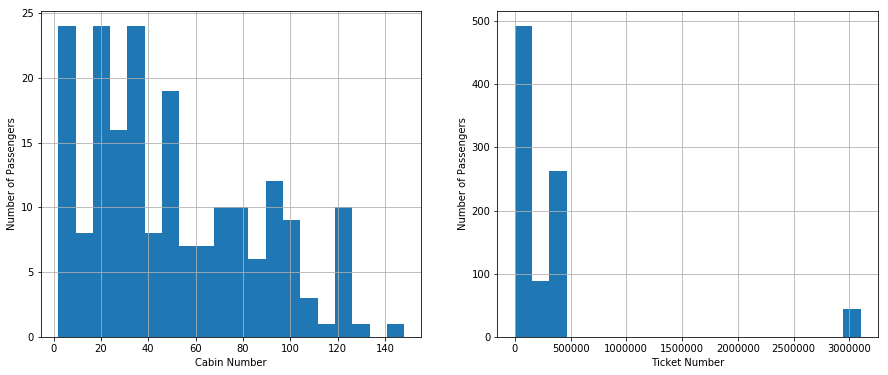

In [34]:
#New nuerical variables: outliers

# first we plot the distributions to find out if they are Gaussian or skewed.
# Depending on the distribution, we will use the normal assumption or the interquantile
# range to find outliers

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
fig = data['Cabin_numerical'].hist(bins=20)
fig.set_ylabel("Number of Passengers")
fig.set_xlabel("Cabin Number")

plt.subplot(1,2,2)
fig = data['Ticket_numerical'].hist(bins=20)
fig.set_ylabel("Number of Passengers")
fig.set_xlabel("Ticket Number")

Text(0,0.5,'Number of Passengers')

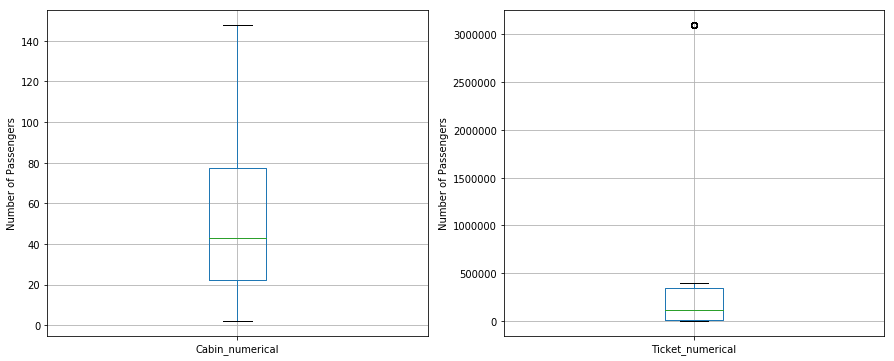

In [35]:
# let's visualise outliers with the boxplot and whiskers

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
fig = data.boxplot(column = 'Cabin_numerical')
fig.set_ylabel("Number of Passengers")

plt.subplot(1,2,2)
fig = data.boxplot(column = 'Ticket_numerical')
fig.set_ylabel("Number of Passengers")


Cabin_numerical does not contain outliers. Ticket_numerical seems to contain a few outliers. Let's find out more about it.

In [36]:
# outliers in Ticket_numerical
IQR = data.Ticket_numerical.quantile(0.75) - data.Ticket_numerical.quantile(0.25)
lower_fence = data.Ticket_numerical.quantile(0.25)- (3*IQR )
upper_fence = data.Ticket_numerical.quantile(0.75) + (3*IQR )

print("Ticket number outlier are values < {lower} or > {upper}".format(lower = lower_fence,upper=upper_fence))

Ticket number outlier are values < -981730.0 or > 1343691.0


We will use equal frequency method to discretize Ticket_numerical

In [37]:
#New categorical variables: Missing values

data[['Cabin_categorical', 'Ticket_categorical', 'Title']].isnull().mean()

Cabin_categorical     0.771044
Ticket_categorical    0.000000
Title                 0.000000
dtype: float64

In [38]:
# New categorical variables: cardinality

for var in ['Cabin_categorical', 'Ticket_categorical', 'Title']:
    print (var, 'contains', len(data[var].unique()))

Cabin_categorical contains 9
Ticket_categorical contains 28
Title contains 5


Title and Cabin are not highly cardinal, Ticket on the other hand has quite a few labels. Let's explore the percentage of passengers within each label to identify rare labels.

In [39]:
# New categorical variables: rare labels

# rare / infrequent labels (less than 1% of passengers)
for var in ['Cabin_categorical', 'Ticket_categorical', 'Title']:
    print(data[var].value_counts()/len(data))

C    0.066218
B    0.052750
D    0.037037
E    0.035915
A    0.016835
F    0.014590
G    0.004489
T    0.001122
Name: Cabin_categorical, dtype: float64
NAN        0.741863
PC         0.067340
CA         0.046016
A          0.031425
STONO      0.020202
SOTONOQ    0.016835
SCPARIS    0.012346
WC         0.011223
SOC        0.006734
FCC        0.005612
C          0.005612
LINE       0.004489
SOPP       0.003367
PP         0.003367
SCAH       0.003367
WEP        0.003367
SOTONO     0.002245
PPP        0.002245
SWPP       0.002245
FA         0.001122
SCOW       0.001122
SC         0.001122
SOP        0.001122
AS         0.001122
SP         0.001122
CASOTON    0.001122
FC         0.001122
SCA        0.001122
Name: Ticket_categorical, dtype: float64
Mr        0.581369
Miss      0.202020
Mrs       0.144781
Master    0.044893
Other     0.026936
Name: Title, dtype: float64


- Cabin contains the rare labels G and T: replace by most frequent category
- Ticket contains a lot of infrequent labels: replace by rare
- Title does not contain rare labels

Because the number of passengers in the rare cabins is so small, grouping them into a new category called rare, will be in itself rare, and may be prone to overfitting. This, in cabin, we will replace rare labels by the most frequent category.

In ticket_categorical, on the other hand, the number of infrequent labels is high, therefore grouping them into a new label makes sense.

### Separate train and test set

In [40]:
X_train,X_test,y_train,y_test = train_test_split(data, data.Survived, test_size = 0.2 , random_state = 0)

X_train.shape, X_test.shape

((712, 16), (179, 16))

In [41]:
# let's group again the variables into categorical or numerical
# now considering the newly created variables

def get_categorical_numerical_variables (dataframe):
    cat_vars = [var for var in dataframe.columns if dataframe[var].dtypes == 'O']
    num_vars = [var for var in dataframe.columns if dataframe[var].dtypes != "O"]
    return cat_vars, num_vars

categorical,numerical = get_categorical_numerical_variables(data)

In [42]:
categorical

['Sex', 'Embarked', 'Cabin_categorical', 'Ticket_categorical', 'Title']

In [43]:
numerical = [var for var in numerical if var not in ['Survived','PassengerId']]
numerical

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin_numerical',
 'Ticket_numerical',
 'Family_size',
 'is_mother']

#### Engineering missing values in numerical variables 

In [44]:
# print variables with missing data
for var in numerical:
    if X_train[var].isnull().mean() > 0:
        print(var, X_train[var].isnull().mean())

Age 0.19803370786516855
Cabin_numerical 0.776685393258427
Ticket_numerical 0.0056179775280898875


- Age and ticket contains < 50% NA: create additional variable with NA + random sample imputation
- Cabin_numerical contains > 50% NA: impute NA by value far in the distribution

In [45]:
def impute_na(X_train, df, variable):
    #make a temporary copy of df
    temp = df.copy()
    # extract random value from train set to fill the na
    random_sample = X_train[variable].dropna().sample(temp[variable].isnull().sum(),random_state = 0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = temp[temp[variable].isnull()].index
    temp.loc[temp[variable].isnull(),variable] = random_sample
    return(temp[variable])

In [46]:
# Replace missing value in Age and ticket

# add variable indicating missingness
for df in [X_train, X_test, submission]:
    for var in ['Age', 'Ticket_numerical']:
        df[var+'_NA'] = np.where(df[var].isnull(),1,0)
        
#  replace by random sampling
for df in [X_train, X_test, submission]:
    for var in ['Age', 'Ticket_numerical']:
        df[var] = impute_na(X_train,df,var)
        
# Cabin numerical
extreme = X_train.Cabin_numerical.mean() + X_train.Cabin_numerical.std()*3
for df in  [X_train, X_test, submission]:
    df.Cabin_numerical.fillna(extreme, inplace = True)

#### Engineering Missing Data in categorical variables 

In [47]:
# print variables with missing data
for var in categorical:
    if X_train[var].isnull().mean()>0:
        print(var,':', X_train[var].isnull().mean())

Embarked : 0.0028089887640449437
Cabin_categorical : 0.7710674157303371


- Embarked NA imputed by most frequent category, because NA is low
- Cabin_categorical imputed by 'Missing', because NA is high

In [49]:
# add label indicating 'Missing' to Cabin categorical
# and replace by most frequent label in Embarked
for df in [X_train, X_test, submission]:
    df['Embarked'].fillna(X_train['Embarked'].mode()[0],inplace = True)
    df['Cabin_categorical'].fillna("Missing", inplace = True)
    

In [50]:
# check if any missing value present after imputation
X_train.isnull().sum()

PassengerId            0
Survived               0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Cabin_numerical        0
Cabin_categorical      0
Ticket_numerical       0
Ticket_categorical     0
Title                  0
Family_size            0
is_mother              0
Age_NA                 0
Ticket_numerical_NA    0
dtype: int64

In [51]:
X_test.isnull().sum()

PassengerId            0
Survived               0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               0
Cabin_numerical        0
Cabin_categorical      0
Ticket_numerical       0
Ticket_categorical     0
Title                  0
Family_size            0
is_mother              0
Age_NA                 0
Ticket_numerical_NA    0
dtype: int64

In [52]:
submission.isnull().sum()

PassengerId            0
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   1
Embarked               0
Cabin_numerical        0
Cabin_categorical      0
Ticket_numerical       0
Ticket_categorical     0
Title                  0
Family_size            0
is_mother              0
Age_NA                 0
Ticket_numerical_NA    0
dtype: int64

In [53]:
# Fare in the submission dataset contains one null value, we will replace it by the median
submission.Fare.fillna(X_train.Fare.median(), inplace = True)

#### Outliers in Numerical variables 

As we saw in the preprocessing stage ther were some outliers and we will replace them as follow:
- Age: top-coding (73)
- Fare: equal frequency binning
- Sibsp: top-coding (4)
- Parch: top-coding (2)
- Family Size: top-coding (7)
- Ticket_number: equal frequency binning

In [54]:
# top encoding
def top_encode(df,variable,top):
    return np.where(df[variable] > top, top, df[variable])

for df in [X_train, X_test, submission]:
    df['Age'] = top_encode(df,'Age',73)
    df['SibSp'] = top_encode(df,'SibSp',4)
    df['Parch'] = top_encode(df,'Parch',2)
    df['Family_size'] = top_encode(df,'Family_size', 7)

In [55]:
# lets check if top encoding worked
for var in ['Age',  'SibSp', 'Parch', 'Family_size']:
    print(var, 'max_value:', X_train[var].max())
        

Age max_value: 73.0
SibSp max_value: 4
Parch max_value: 2
Family_size max_value: 7


In [56]:
for var in ['Age',  'SibSp', 'Parch', 'Family_size']:
    print(var, 'max_value:', X_test[var].max())

Age max_value: 64.0
SibSp max_value: 4
Parch max_value: 2
Family_size max_value: 7


In [57]:
for var in ['Age',  'SibSp', 'Parch', 'Family_size']:
    print(var, 'max_value:', submission[var].max())

Age max_value: 73.0
SibSp max_value: 4
Parch max_value: 2
Family_size max_value: 7


In [58]:
# find quantiles and discretise Fare
X_train['Fare'], bins = pd.qcut(x=X_train['Fare'], q=8, retbins=True, precision=3, duplicates='raise')
X_test['Fare'] = pd.cut(x = X_test['Fare'], bins=bins, include_lowest=True)
submission['Fare'] = pd.cut(x = submission['Fare'], bins=bins, include_lowest=True)


In [59]:
submission.Fare.isnull().sum()

0

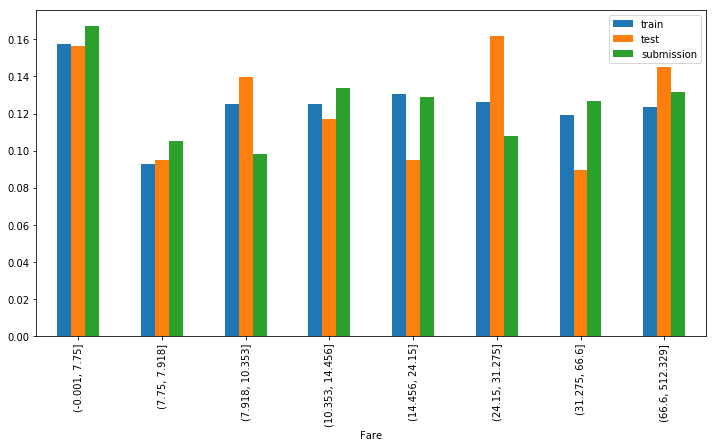

In [60]:
# check if the Fare is equally distribute across the bins
t1 = X_train.groupby(['Fare'])['Fare'].count() / np.float(len(X_train))
t2 = X_test.groupby(['Fare'])['Fare'].count() / np.float(len(X_test))
t3 = submission.groupby(['Fare'])['Fare'].count() / np.float(len(submission))
 
temp = pd.concat([t1,t2,t3], axis=1)
temp.columns = ['train', 'test', 'submission']
temp.plot.bar(figsize=(12,6))

In [61]:
# find quantiles and discretise ticket numerical
X_train['Ticket_numerical'] , bins = pd.qcut(x = X_train['Ticket_numerical'], q=8, precision=3,retbins=True,duplicates='raise')
X_test['Ticket_numerical'] = pd.cut(x = X_test['Ticket_numerical'], bins=bins, include_lowest=True)
submission['Ticket_numerical_temp'] = pd.cut(x = submission['Ticket_numerical'], bins = bins, include_lowest=True)

In [62]:
# check if any still missing data
X_test.Ticket_numerical.isnull().sum()

0

In [63]:
submission['Ticket_numerical_temp'].isnull().sum()

2

In [64]:
submission[submission['Ticket_numerical_temp'].isnull()][['Ticket_numerical','Ticket_numerical_temp']]

,Ticket_numerical,Ticket_numerical_temp
186,2.0,NaN
302,2.0,NaN


There are 2 values of ticket in the submission dataset, that could not be placed within the intervals calculated for the training set. let's look at the intervals to understand why this could have been the case.

In [65]:
# getting the intervals of ticket numerical for train data
X_train['Ticket_numerical'].unique()

[(2.999, 2816.875], (14737.5, 24421.875], (364848.0, 3101317.0], (24421.875, 113053.0], (248701.0, 347077.25], (113053.0, 248701.0], (2816.875, 14737.5], (347077.25, 364848.0]]
Categories (8, interval[float64]): [(2.999, 2816.875] < (2816.875, 14737.5] < (14737.5, 24421.875] < (24421.875, 113053.0] < (113053.0, 248701.0] < (248701.0, 347077.25] < (347077.25, 364848.0] < (364848.0, 3101317.0]]

The lowest bin starts at 2.99, and the values for the tickets in the submission are 2, so slight below the interval. We will bottom code the variable, and include those 2 values within the lowest interval. 

In [66]:
submission.loc[submission['Ticket_numerical_temp'].isnull(),'Ticket_numerical_temp'] = X_train['Ticket_numerical'].unique()[0]
submission['Ticket_numerical_temp'].isnull().sum()

0

In [67]:
# drop the temp varaible
submission['Ticket_numerical'] = submission['Ticket_numerical_temp']
submission.drop('Ticket_numerical_temp', axis = 1, inplace = True)
submission.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
0,892,3,male,34.5,0,0,"(7.75, 7.918]",Q,158.222059,Missing,"(248701.0, 347077.25]",NAN,Mr,1,0,0,0
1,893,3,female,47.0,1,0,"(-0.001, 7.75]",S,158.222059,Missing,"(347077.25, 364848.0]",NAN,Mrs,2,0,0,0
2,894,2,male,62.0,0,0,"(7.918, 10.353]",Q,158.222059,Missing,"(113053.0, 248701.0]",NAN,Mr,1,0,0,0
3,895,3,male,27.0,0,0,"(7.918, 10.353]",S,158.222059,Missing,"(248701.0, 347077.25]",NAN,Mr,1,0,0,0
4,896,3,female,22.0,1,1,"(10.353, 14.456]",S,158.222059,Missing,"(364848.0, 3101317.0]",NAN,Mrs,3,1,0,0


#### Engineering rare labels in categorical variables 

In [68]:
# find infrequent labels in categorical variables

for  var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

Sex male      0.65309
female    0.34691
Name: Sex, dtype: float64

Embarked S    0.728933
C    0.181180
Q    0.089888
Name: Embarked, dtype: float64

Cabin_categorical Missing    0.771067
C          0.061798
B          0.050562
E          0.040730
D          0.036517
A          0.021067
F          0.012640
G          0.004213
T          0.001404
Name: Cabin_categorical, dtype: float64

Ticket_categorical NAN        0.728933
PC         0.066011
CA         0.050562
A          0.035112
STONO      0.023876
SOTONOQ    0.016854
WC         0.014045
SCPARIS    0.014045
SOC        0.007022
LINE       0.005618
C          0.005618
WEP        0.004213
PP         0.004213
PPP        0.002809
SOTONO     0.002809
FCC        0.002809
SOPP       0.002809
SCAH       0.002809
SCOW       0.001404
SWPP       0.001404
AS         0.001404
FC         0.001404
SP         0.001404
SCA        0.001404
FA         0.001404
Name: Ticket_categorical, dtype: float64

Title Mr        0.589888
Miss      0.200843
Mrs   

- Cabin contains the rare labels G and T: replace by most frequent category
- Ticket contains a lot of infrequent labels: replace by rare

Because the number of passengers in the rare cabins is so small, grouping them into a new category called rare, will be in itself rare, and may be prone to overfitting. Thus, in cabin, we will replace rare labels by the most frequent category. In ticket_categorical, on the other hand, the number of infrequent labels is high, therefore grouping them into a new label makes sense.

In [69]:
def rare_imputation(variable, which = 'rare'):
    # find frequent labels
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.01].index.values]
    
    # create new variables, with Rare labels imputed
    if which=='frequent':
        # find the most frequent category
        mode_label = X_train.groupby(variable)[variable].count().sort_values().tail(1).index.values[0]
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], mode_label)
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], mode_label)
        submission[variable] = np.where(submission[variable].isin(frequent_cat), submission[variable], mode_label)
    
    else:
        X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
        X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
        submission[variable] = np.where(submission[variable].isin(frequent_cat), submission[variable], 'Rare')

In [70]:
# impute the rare labels in categorical varaibles
rare_imputation('Cabin_categorical','frequent')
rare_imputation('Ticket_categorical','rare')

In [71]:
# lets check if the rare label imputation worked
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

Sex male      0.65309
female    0.34691
Name: Sex, dtype: float64

Embarked S    0.728933
C    0.181180
Q    0.089888
Name: Embarked, dtype: float64

Cabin_categorical Missing    0.776685
C          0.061798
B          0.050562
E          0.040730
D          0.036517
A          0.021067
F          0.012640
Name: Cabin_categorical, dtype: float64

Ticket_categorical NAN        0.728933
PC         0.066011
CA         0.050562
Rare       0.050562
A          0.035112
STONO      0.023876
SOTONOQ    0.016854
SCPARIS    0.014045
WC         0.014045
Name: Ticket_categorical, dtype: float64

Title Mr        0.589888
Miss      0.200843
Mrs       0.140449
Master    0.049157
Other     0.019663
Name: Title, dtype: float64



In [72]:
# for submission data
for var in categorical:
    print(var, submission[var].value_counts()/np.float(len(submission)))
    print()

Sex male      0.636364
female    0.363636
Name: Sex, dtype: float64

Embarked S    0.645933
C    0.244019
Q    0.110048
Name: Embarked, dtype: float64

Cabin_categorical Missing    0.784689
C          0.083732
B          0.043062
D          0.031100
E          0.021531
F          0.019139
A          0.016746
Name: Cabin_categorical, dtype: float64

Ticket_categorical NAN        0.708134
PC         0.076555
Rare       0.064593
CA         0.064593
A          0.026316
SOTONOQ    0.021531
SCPARIS    0.019139
WC         0.011962
STONO      0.007177
Name: Ticket_categorical, dtype: float64

Title Mr        0.574163
Miss      0.186603
Mrs       0.172249
Master    0.050239
Other     0.016746
Name: Title, dtype: float64



#### Encode categorical variables 

In [73]:
categorical

['Sex', 'Embarked', 'Cabin_categorical', 'Ticket_categorical', 'Title']

We will encode as follow:
- Sex: one hot encoding
- Remaining variables: replace by risk probability

In [74]:
# Sex
for df in [X_train, X_test, submission]:
    df['Sex'] = pd.get_dummies(df['Sex'],drop_first=True)

In [75]:
X_train.Sex.unique()

array([0, 1], dtype=uint64)

In [76]:
# function for encoding by risk probability
def encode_categorical_variable(var, target):
    #create dictionary to store risk probability by labels
    ordered_labels = X_train.groupby([var])[target].mean().to_dict()
    
    #encode variables
    X_train[var] = X_train[var].map(ordered_labels)
    X_test[var] = X_test[var].map(ordered_labels)
    submission[var] = submission[var].map(ordered_labels)
    
# apply the function
for var in categorical:
    encode_categorical_variable(var,'Survived')

In [77]:
# encoding the discretised variables Fare and Ticket_numerical

# parse the discretised variables as object before encoding
for df in [X_train,X_test, submission]:
    df['Fare'] = df['Fare'].astype('O')
    df['Ticket_numerical'] = df['Ticket_numerical'].astype('O')

In [78]:
# encode the labels
for var in ['Fare','Ticket_numerical']:
    encode_categorical_variable(var, 'Survived')

In [79]:
# inspect the tranformed data
X_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
140,141,0,3,0.744939,27.0,0,2,0.397849,0.527132,158.222059,0.307414,0.348315,0.394990,0.790000,3,0,1,0
439,440,0,2,0.191398,31.0,0,0,0.404494,0.342967,158.222059,0.307414,0.573034,0.305556,0.157143,1,0,0,0
817,818,0,2,0.191398,31.0,1,1,0.494118,0.527132,158.222059,0.307414,0.348315,0.500000,0.157143,3,0,0,0
378,379,0,3,0.191398,20.0,0,0,0.223214,0.527132,158.222059,0.307414,0.348315,0.394990,0.157143,1,0,0,0
491,492,0,3,0.191398,21.0,0,0,0.223214,0.342967,158.222059,0.307414,0.306818,0.166667,0.157143,1,0,0,0


#### Feature Scaling

In [80]:
X_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_numerical,Cabin_categorical,Ticket_numerical,Ticket_categorical,Title,Family_size,is_mother,Age_NA,Ticket_numerical_NA
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,443.283708,0.383427,2.317416,0.383427,29.807584,0.484551,0.353933,0.383427,0.383427,133.956178,0.383427,0.383427,0.383427,0.383427,1.875000,0.067416,0.198034,0.005618
std,260.003783,0.486563,0.833767,0.263664,14.496489,0.907718,0.673811,0.144616,0.071238,48.398112,0.149408,0.118238,0.098434,0.276532,1.460148,0.250917,0.398798,0.074795
min,1.000000,0.000000,1.000000,0.191398,0.670000,0.000000,0.000000,0.212121,0.342967,2.000000,0.307414,0.166667,0.080000,0.157143,1.000000,0.000000,0.000000,0.000000
25%,211.750000,0.000000,2.000000,0.191398,21.000000,0.000000,0.000000,0.232770,0.342967,158.222059,0.307414,0.321087,0.394990,0.157143,1.000000,0.000000,0.000000,0.000000
50%,441.000000,0.000000,3.000000,0.191398,28.750000,0.000000,0.000000,0.397849,0.342967,158.222059,0.307414,0.370787,0.394990,0.157143,1.000000,0.000000,0.000000,0.000000
75%,671.250000,1.000000,3.000000,0.744939,38.000000,1.000000,0.000000,0.444444,0.421875,158.222059,0.307414,0.474719,0.394990,0.706294,2.000000,0.000000,0.000000,0.000000
max,890.000000,1.000000,3.000000,0.744939,73.000000,4.000000,2.000000,0.659091,0.527132,158.222059,0.758621,0.573034,0.617021,0.790000,7.000000,1.000000,1.000000,1.000000


In [81]:
# variables required scaling
variables_to_scale = ['Pclass', 'Age', 'Sibsp', 'Parch', 'Cabin_numerical', 'Family_size']

In [82]:
# remove passengerId and Survived from trainning features
training_vars = [var for var in X_train.columns if var not in ['PassengerId','Survived']]
training_vars

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Cabin_numerical',
 'Cabin_categorical',
 'Ticket_numerical',
 'Ticket_categorical',
 'Title',
 'Family_size',
 'is_mother',
 'Age_NA',
 'Ticket_numerical_NA']

In [83]:
# fit scalar
scalar = MinMaxScaler()
scalar.fit(X_train[training_vars])

MinMaxScaler(copy=True, feature_range=(0, 1))

### Machine Learning Modeling

#### XgBoost

In [93]:
xgb_model = xgb.XGBClassifier()

eval_set =[(X_test[training_vars],y_test)]
xgb_model.fit(X_train[training_vars],y_train, eval_metric = 'auc', eval_set = eval_set, verbose = False)

pred = xgb_model.predict_proba(X_train[training_vars])
print('xgb_train roc_auc :{}'.format(roc_auc_score(y_train,pred[:,1])))

pred = xgb_model.predict_proba(X_test[training_vars])
print('xgb_test roc_auc :{}'.format(roc_auc_score(y_test,pred[:,1])))

xgb_train roc_auc :0.9388929218086394
xgb_test roc_auc :0.9077733860342556


#### Random Forest

In [94]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train[training_vars], y_train)
 
pred = rf_model.predict_proba(X_train[training_vars])
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = rf_model.predict_proba(X_test[training_vars])
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

RF train roc-auc: 0.998656620524502
RF test roc-auc: 0.8959156785243741


In [95]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train[training_vars], y_train)
 
pred = ada_model.predict_proba(X_train[training_vars])
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(X_test[training_vars])
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Adaboost train roc-auc: 0.897344113745025
Adaboost test roc-auc: 0.8706192358366271


In [96]:
logit_model = LogisticRegression()
logit_model.fit(scalar.transform(X_train[training_vars]), y_train)
 
pred = logit_model.predict_proba(scalar.transform(X_train[training_vars]))
print('Logit train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(scalar.transform(X_test[training_vars]))
print('Logit test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))


Logit train roc-auc: 0.8724915934483133
Logit test roc-auc: 0.8268774703557312


In [97]:
# Bagging the model results : Averaging

pred_ls = []
for model in [xgb_model, rf_model, ada_model, logit_model]:
    pred_ls.append(pd.Series(model.predict_proba(X_test[training_vars])[:,1]))
    
final_pred = pd.concat(pred_ls, axis = 1).mean(axis = 1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_pred)))

Ensemble test roc-auc: 0.9068511198945981


#### Finding best threshold for maximum accuracy

In [99]:
tpr, fpr, thresholds = metrics.roc_curve(y_test,final_pred)
thresholds

array([1.62887334, 0.62887334, 0.59998138, 0.59904189, 0.53320108,
       0.5111278 , 0.48829908, 0.48676485, 0.41070188, 0.36205063,
       0.35911698, 0.35090368, 0.34411429, 0.32975272, 0.32614494,
       0.32075407, 0.32020933, 0.31398448, 0.3132235 , 0.31228817,
       0.30182098, 0.30137827, 0.2978687 , 0.28647033, 0.28621705,
       0.27866244, 0.27421405, 0.26542114, 0.26005321, 0.25779934,
       0.25442576, 0.253148  , 0.24452678, 0.18531562, 0.18403145,
       0.18093572, 0.1797722 , 0.1671986 , 0.16682324, 0.15642795,
       0.15534344, 0.15083521, 0.15075582, 0.14506151, 0.14492661,
       0.14461142, 0.14448713, 0.14381655, 0.14054127, 0.13656845,
       0.13573485, 0.12935124, 0.12787358])

In [100]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_pred > thres, 1, 0)
    accuracy_ls.append(metrics.accuracy_score(y_test,y_pred, normalize = True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)], axis = 1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by = 'accuracy', ascending = False, inplace = True)
accuracy_ls.head()

,thresholds,accuracy
8,0.410702,0.860335
12,0.344114,0.843575
11,0.350904,0.837989
7,0.486765,0.837989
9,0.362051,0.837989


#### Submission to kaggle

In [103]:
pred_ls = []
for model in [xgb_model, rf_model, ada_model, logit_model]:
    pred_ls.append(pd.Series(model.predict_proba(submission[training_vars])[:,1]))

final_pred = pd.concat(pred_ls, axis = 1).mean(axis = 1)

In [104]:
final_pred = pd.Series(np.where(final_pred > 0.41, 1, 0))

In [105]:
temp = pd.concat([submission.PassengerId, final_pred], axis = 1)
temp.columns = ['PassengerId', 'Survived']
temp.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [106]:
temp.to_csv('submit_titanic.csv')

#### Feature Importance

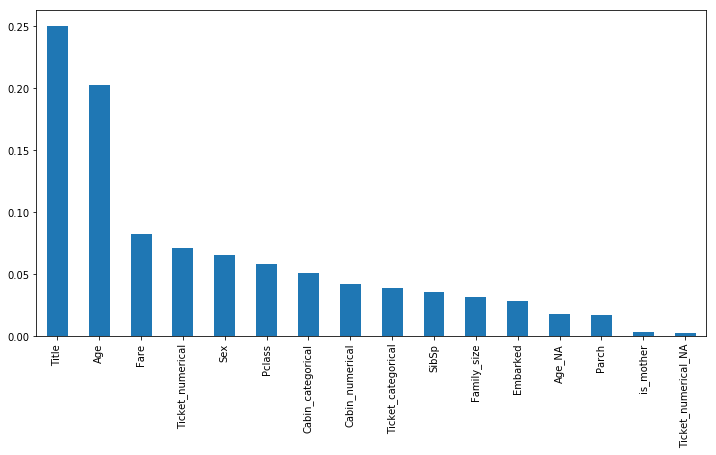

In [108]:
importance = pd.Series(rf_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace = True, ascending = False)
importance.plot.bar(figsize=(12,6))

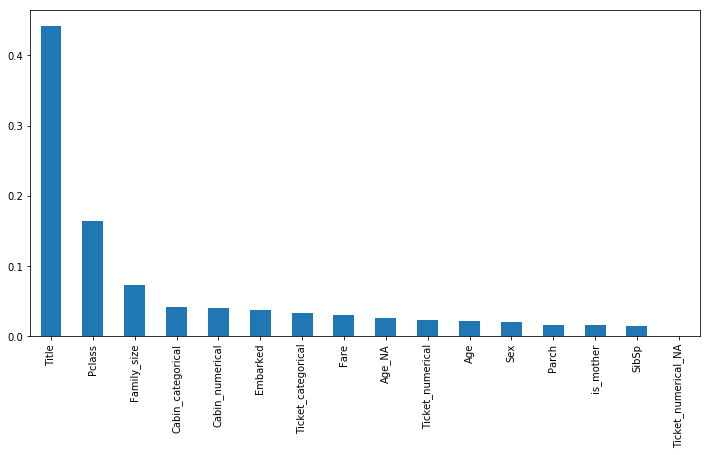

In [109]:
importance = pd.Series(xgb_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace = True, ascending = False)
importance.plot.bar(figsize=(12,6))

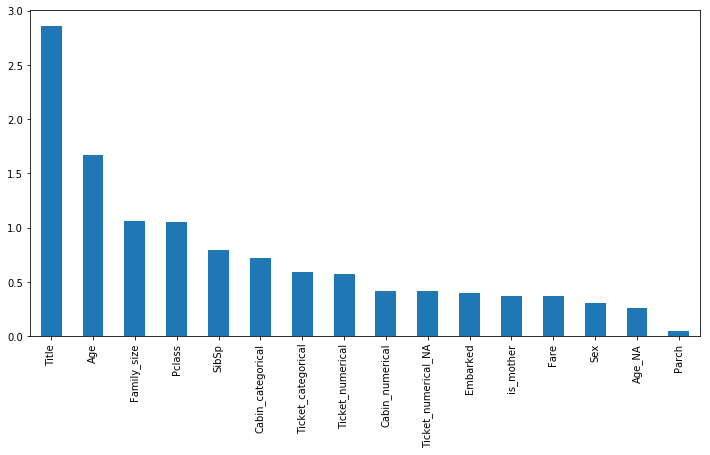

In [112]:
importance = pd.Series(np.abs(logit_model.coef_.ravel()))
importance.index = training_vars
importance.sort_values(inplace = True, ascending = False)
importance.plot.bar(figsize=(12,6))